In [1]:
import os
import pickle
import shutil 

import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from IPython import embed

Using MPI version 4.0, 1 processes


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# set up simulation constants

resolution = 20

n_air = 1.0000003
n_Si = 1.45
n_SiO2 = 3.48

a = 0.5   # lattice period 

#pml_thickness = round(wavelength / 2,3)
pml_thickness = 0.780
height_hole = 5
height_SiO2 = height_hole
height_air = 7+2*pml_thickness
height_Si_initial= 0.5*(height_air-height_hole)
height_Si_add = 0.75*0.5*height_SiO2


cell_x = a
cell_y = a
cell_z = height_air

z_air = height_air

center_air = 0 
center_SiO2 = 0 
center_hole = 0
center_Si_initial = -0.5*height_hole -0.25*(height_air-height_hole)+0.005
center_Si_add = 0.5*height_Si_add

min = 0.0
max = 0.245


#z_siox = pml_thickness + height_siox +height_space


-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00176406 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
time for set_epsilon = 0.042686 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
62.56561325697375


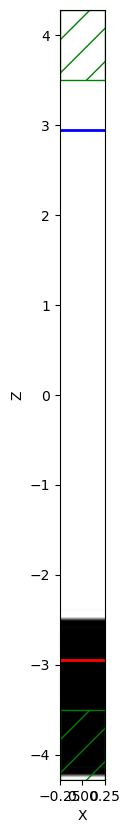

In [3]:
#initial_geometry setup

cell_size = mp.Vector3(cell_x,cell_y,cell_z)
pml_layers = [mp.PML(thickness = pml_thickness, direction = mp.Z)]

geometry = [mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_air), 
                    center=mp.Vector3(0,0,center_air),
                    material=mp.Medium(index=n_air)),
           mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_Si_initial),
                   center=mp.Vector3(0,0,center_Si_initial),
                   material=mp.Medium(index=n_Si))]


k_point = mp.Vector3(0,0,0)

## source ##
center_source = -0.5*height_hole-0.125*(height_air-height_hole) 
source_cmpt = mp.Ey

wavelength = 1.55
freq = 1 / wavelength


sources = [mp.Source(mp.ContinuousSource(frequency=freq),
                    component=source_cmpt,
                    center=mp.Vector3(0,0,center_source),
                    size=mp.Vector3(cell_x,cell_y,0))]


## flux monitor ##
nfreq = 1
df = 0
fr_center = 0.5*height_hole+0.125*(height_air-height_hole)
fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
            size=mp.Vector3(cell_x, cell_y, 0))



if source_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X, phase=+1), #epsilon has mirror symmetry in x and y, phase doesn't matter
                  mp.Mirror(mp.Y, phase=-1)] #but sources have -1 phase when reflected normal to their direction
elif src_cmpt == mp.Ex:                      #use of symmetries important here, significantly speeds up sim
    symmetries = [mp.Mirror(mp.X, phase=-1),
                  mp.Mirror(mp.Y, phase=+1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X, phase=+1),
                  mp.Mirror(mp.Y, phase=+1)]


sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=sources,
                    k_point=k_point,
                    boundary_layers=pml_layers,
                    symmetries=symmetries,
                    resolution=resolution)
flux_object = sim.add_flux(freq, df, nfreq, fr)


sim.run(until=200)


## plot initial geometry ##
fig = plt.figure(figsize=(10,10))
plot_plane = mp.Volume(center=mp.Vector3(0,0.0*a,0),
                            size=mp.Vector3(a,0,cell_z))
sim.plot2D(output_plane=plot_plane
           #fields=mp.Ey
           )
plt.grid(False)

initial_flux = mp.get_fluxes(flux_object)[0]
print(initial_flux)


     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)


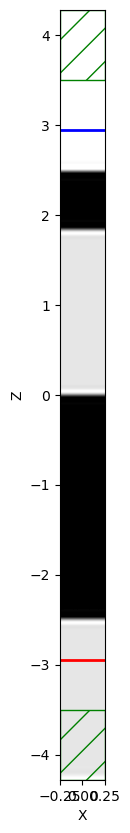

In [4]:
geometry.append(mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_SiO2), 
                    center=mp.Vector3(0,0,center_SiO2),
                    material=mp.Medium(index=n_SiO2)))

geometry.append(mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_Si_add), 
                    center=mp.Vector3(0,0,center_Si_add),
                    material=mp.Medium(index=n_Si)))
                
fig = plt.figure(figsize=(10,10))
plot_plane = mp.Volume(center=mp.Vector3(0,0.0*a,0),
                            size=mp.Vector3(a,0,cell_z))
sim.plot2D(output_plane=plot_plane
           #fields=mp.Ey
           )
plt.grid(False)


## initialize matrix for data collection ##
##########################################

num = 15 # this is the number of pillars we will build
data = np.zeros((3,num))





In [5]:
sim.reset_meep()

pbar = tqdm(total=num,leave=False)
for i,radius in enumerate(np.linspace(min,max,num=num)):

    geometry.append(mp.Cylinder(radius=radius,
                        height=height_hole,
                        axis=mp.Vector3(0,0,1),
                        center=mp.Vector3(0,0,center_hole),
                        material=mp.Medium(index=n_air)))
                                
    #geometry=mp.Cylinder(radius=radius,


    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        sources=sources,
                        k_point=k_point,
                        boundary_layers=pml_layers,
                        symmetries=symmetries,
                        resolution=resolution)

    flux_object = sim.add_flux(freq, df, nfreq, fr)  

    sim.run(until=200)
    
    res = sim.get_eigenmode_coefficients(flux_object, [1], eig_parity=mp.ODD_Y)
    coeffs = res.alpha

    flux = abs(coeffs[0,0,0]**2)
    phase = np.angle(coeffs[0,0,0]) 
    
    data[0,i] = radius
    data[1,i] = flux
    data[2,i] = phase

    
    if(radius!=max):
        sim.reset_meep()
        print(f"i= {i},radius={radius}")
        geometry.pop(-1)
    pbar.update(1)
pbar.close()

## pickle operations

#from IPython import embed; embed()

  0%|                                                                          | 0/15 [00:00<?, ?it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00184989 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0)
          r

FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


  7%|████▍                                                             | 1/15 [00:01<00:19,  1.40s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 0,radius=0.0
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00170708 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,

FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 13%|████████▊                                                         | 2/15 [00:02<00:18,  1.39s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 1,radius=0.017499999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00170088 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylin

FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 20%|█████████████▏                                                    | 3/15 [00:04<00:16,  1.40s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 2,radius=0.034999999999999996
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.0016861 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylind

FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 27%|█████████████████▌                                                | 4/15 [00:05<00:15,  1.45s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 3,radius=0.05249999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00169301 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylind

FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 33%|██████████████████████                                            | 5/15 [00:07<00:14,  1.48s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 4,radius=0.06999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00170016 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylind

FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 40%|██████████████████████████▍                                       | 6/15 [00:08<00:13,  1.49s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 5,radius=0.0875
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00165987 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = 

FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 47%|██████████████████████████████▊                                   | 7/15 [00:10<00:12,  1.51s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 6,radius=0.10499999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00166202 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylind

FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 53%|███████████████████████████████████▏                              | 8/15 [00:11<00:10,  1.50s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 7,radius=0.12249999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00169897 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylind

FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 60%|███████████████████████████████████████▌                          | 9/15 [00:13<00:09,  1.51s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 8,radius=0.13999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00166082 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylind

FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 67%|███████████████████████████████████████████▎                     | 10/15 [00:14<00:07,  1.52s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 9,radius=0.15749999999999997
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00167203 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylind

FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 73%|███████████████████████████████████████████████▋                 | 11/15 [00:16<00:06,  1.51s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 10,radius=0.175
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.0016582 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (

FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 80%|████████████████████████████████████████████████████             | 12/15 [00:17<00:04,  1.52s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 11,radius=0.19249999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00163698 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylin

FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 87%|████████████████████████████████████████████████████████▎        | 13/15 [00:19<00:03,  1.53s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 12,radius=0.20999999999999996
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00166893 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylin

FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


 93%|████████████████████████████████████████████████████████████▋    | 14/15 [00:20<00:01,  1.53s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 13,radius=0.22749999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00164795 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylin

FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,0)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0.9375)
          size (1e+20,1e+20,1.875)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0)
          radius 0.245, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)



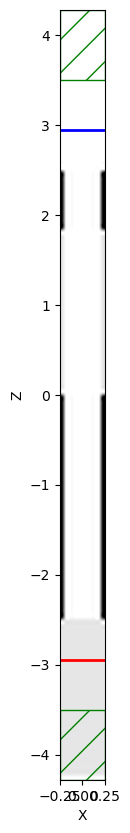

In [7]:
plt.figure(figsize=(10,10))
plot_plane = mp.Volume(center=mp.Vector3(0,0.0*a,0),
                            size=mp.Vector3(a,0,cell_z))
field_func = lambda x: 20*np.log10(np.abs(x))
sim.plot2D(output_plane=plot_plane,
           #fields=mp.Ey
           )
plt.grid(False)

print()

In [ ]:
import pickle
data = pickle.load(open("data.pkl", "rb"))
initial_flux = pickle.load(open("initial_flux.pkl","rb"))

In [ ]:
radii = data[0,:]
flux_list = data[1,0:] / initial_flux
phase_list = data[2,0:]

#plt.style.use('seaborn')

results = {"radii": radii, "flux": flux_list, "phase": phase_list}
# this section plots radius vs. phas and transmission

tickfontsize=22
labelfontsize=26
titlefontsize=30

fig,ax = plt.subplots(figsize=(8,5)) # may want to change. Also see DPI keyword

fig.suptitle("Meta-atom Transmission",fontsize=titlefontsize)

#ax.set_title("Transmission Magnitude",fontsize=titlefontsize)

ax.set_xlabel("Radius",fontsize=labelfontsize)
ax.set_xticks([0.000,0.050,0.100,0.150,0.200,0.250])
ax.set_xticklabels([0,50,100,150,200,250],fontsize=tickfontsize)
ax.set_ylim([0,1])
ax.set_ylabel(r'Percent Transmitted ($\%$)',fontsize=labelfontsize, color = 'blue')
#ax.plot(radii,flux_list,'b',label='Transmission')
ax.plot(radii, flux_list, 'b', label='Transmission')
ax.tick_params(axis='y', labelcolor = 'blue')

ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0, 20,40,60,80,100],fontsize=tickfontsize)
#ax.set_yticks([0.6,0.7,0.8,0.9,1])
#ax.set_yticklabels([60,70,80,90,100],fontsize=ticgit config --global user.email "you@example.com"kfontsize)

twin1 = ax.twinx()
#ax[1].set_title("Transmission Phase",fontsize=titlefontsize)S
#ax[1].set_xlabel("Radius (nm)",fontsize=labelfontsize)
#ax[1].set_xticks([0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250])cd meep

#ax[1].set_xticklabels([75,100,125,150,175,200,225,250],fontsize=tickfontsize)
twin1.set_ylim([-np.pi,np.pi])
twin1.set_ylabel(r'Phase Delay (rad)',fontsize=labelfontsize, color = 'red')
twin1.set_yticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
twin1.set_yticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
twin1.plot(radii,phase_list,'r',label='Phase')
twin1.tick_params(axis='y', labelcolor = 'red')
#ax[1].legend(loc="upper right")
#plt.legend(loc="upper right")
plt.grid(False)
plt.tight_layout()




In [ ]:
print(flux_list)